# Preprocessing

In [6]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
%autoreload 2

In [8]:
import torch

In [9]:
from src.vfm.connection import Connection
from src.vfm.preprocessor import Preprocessor
from src.vfm.resampler import Resampler
from src.utils.descriptive_utils import *
from src.vfm.model.physics.physics_informed import PhysicsInformedHybridModel
from src.utils import *
import json

In [10]:
connection = Connection()
# Get client
client = connection.get_client()

In [11]:
df_all_wells = connection.get_data(client, wells=get_all_wells())
df_all_wells.columns

Index(['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'qo_well_test',
       'qg_well_test', 'qw_well_test', 'qo_mpfm', 'qg_mpfm', 'wc_mpfm',
       'well_id'],
      dtype='object')

In [12]:
dependent_vars=get_depdendent_vars()
independent_vars=get_independent_vars()

In [15]:
preprocessor = Preprocessor()
df_all_wells_preprocessed = preprocessor.preprocess_wells(df=df_all_wells)
len(df_all_wells_preprocessed)

Preprocessing well W06 with columns ['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'qo_well_test', 'qg_well_test', 'qw_well_test', 'qo_mpfm', 'qg_mpfm', 'wc_mpfm', 'well_id']
Preprocessing well W08 with columns ['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'qo_well_test', 'qg_well_test', 'qw_well_test', 'qo_mpfm', 'qg_mpfm', 'wc_mpfm', 'well_id']
Preprocessing well W10 with columns ['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'qo_well_test', 'qg_well_test', 'qw_well_test', 'qo_mpfm', 'qg_mpfm', 'wc_mpfm', 'well_id']
Preprocessing well W11 with columns ['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'qo_well_test', 'qg_well_test', 'qw_well_test', 'qo_mpfm', 'qg_mpfm', 'wc_mpfm', 'well_id']
Preprocessing well W15 with columns ['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'qo_well_test', 'qg_well_test', 'qw_well_test', 'qo_mpfm', 'qg_mpfm', 'wc_mpfm', 'well_id']
Preprocessing well W18 with columns ['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'qo_well_test', 'qg_well_test', 'qw_well_test', 'qo_mp

755

In [16]:
summarize_null(df_all_wells_preprocessed)

qo_well_test      0
qg_well_test      0
qw_well_test      0
well_code         0
dhp               0
dht               0
whp               0
wht               0
choke             0
dcp               0
qo_mpfm          30
qg_mpfm          30
qw_mpfm          30
wc_mpfm           0
gor_mpfm         35
wgr_mpfm         36
gor_well_test     0
wgr_well_test     0
well_id           0
time_idx          0
dtype: int64

In [17]:
df_train, df_val, df_test = get_random_train_test_split_per_well_with_order_preserved(df=df_all_wells_preprocessed)
len(df_train), len(df_val), len(df_test)

(512, 96, 147)

In [18]:
well_geometry: dict = None

with open(r"data\well_geometry.json", "r") as f:
    well_geometry = json.load(f)



In [19]:
model = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars, well_geometry=well_geometry,
)
model.fit(df=df_train, df_val=df_val)

[Validation] Residual RMSE = 0.7335


In [20]:
model.score_physics(df_test)

{'W06': {'qo': {'r2': 0.7007745446958416,
   'mae': 13.295330632716562,
   'rmse': 17.49099581574686,
   'mape (%)': 13.535467796746914,
   'mpe (%)': 3.6101913595525246},
  'qw': {'r2': 0.047668928811370415,
   'mae': 1.0424206906768934,
   'rmse': 1.279908750831264,
   'mape (%)': 14922.426927294904,
   'mpe (%)': 14887.907994540394},
  'qg': {'r2': 0.5218532681925091,
   'mae': 2311.073724860413,
   'rmse': 2828.5180090142053,
   'mape (%)': 13.905259856074087,
   'mpe (%)': -12.671021405428128},
  'wgr': {'r2': -0.2217242881505428,
   'mae': 7.072565330245074e-05,
   'rmse': 9.41294628979787e-05,
   'mape (%)': 210.83405689563338,
   'mpe (%)': 180.8553720462841},
  'gor': {'r2': -161.41248188686035,
   'mae': 17.047359183673173,
   'rmse': 24.252397894194075,
   'mape (%)': 13.784287978434351,
   'mpe (%)': -13.093282001667431}},
 'W08': {'qo': {'r2': 0.14587698473366406,
   'mae': 8.975001015924995,
   'rmse': 10.827534081202568,
   'mape (%)': 44.09111130749152,
   'mpe (%)': 15

In [21]:
model.score_hybrid(df_test)

{'W06': {'qo': {'r2': 0.8153724054872804,
   'mae': 9.80882709348712,
   'rmse': 13.739267313953459,
   'mape (%)': 7.575258081849652,
   'mpe (%)': -2.350018355344738},
  'qw': {'r2': -1.2697114084096763,
   'mae': 1.4778744543101279,
   'rmse': 1.975924524810023,
   'mape (%)': 100.0,
   'mpe (%)': -100.0},
  'qg': {'r2': 0.8539335622116753,
   'mae': 1233.7811747528904,
   'rmse': 1563.3404729388308,
   'mape (%)': 8.356634311751305,
   'mpe (%)': -3.4993466598795484},
  'wgr': {'r2': -1.6954963698754955,
   'mae': 0.00011088872981410475,
   'rmse': 0.00013981647618356604,
   'mape (%)': 100.0,
   'mpe (%)': -100.0},
  'gor': {'r2': -71.060401148859,
   'mae': 11.435624208502977,
   'rmse': 16.15449257457778,
   'mape (%)': 9.241240720928504,
   'mpe (%)': -0.3811921276410451}},
 'W08': {'qo': {'r2': 0.12499624616174332,
   'mae': 7.634626673472415,
   'rmse': 10.959085248200696,
   'mape (%)': 31.076790310090374,
   'mpe (%)': -3.3236855360423387},
  'qw': {'r2': 0.7074830707237303

In [22]:
model.score_mpfm(df=df_test)

{'W06': {'qo': {'r2': 0.9484893884159058,
   'mae': 5.934943058951249,
   'rmse': 7.257108576644873,
   'mape (%)': 4.335640163702027,
   'mpe (%)': 4.335640163702027},
  'qw': {'r2': -0.9323966420447753,
   'mae': 1.3785006942806142,
   'rmse': 1.8231951984571286,
   'mape (%)': 171.40898063605158,
   'mpe (%)': -8.481917473736527},
  'qg': {'r2': 0.9616479078843737,
   'mae': 570.8143989073554,
   'rmse': 801.0744536861558,
   'mape (%)': 3.750494198535783,
   'mpe (%)': 3.750494198535783},
  'wgr': {'r2': -1.456878363456239,
   'mae': 0.00010475033988108963,
   'rmse': 0.0001334844893911225,
   'mape (%)': 95.65573203786705,
   'mpe (%)': -95.65573203786705},
  'gor': {'r2': -9.027818505879493,
   'mae': 4.0989406028954605,
   'rmse': 6.026264865865639,
   'mape (%)': 3.2833837924934897,
   'mpe (%)': -0.49097055185482835}},
 'W08': {'qo': {'r2': 0.8263378340347358,
   'mae': 3.9947790883755125,
   'rmse': 4.882271806018076,
   'mape (%)': 24.832683564057497,
   'mpe (%)': 3.9919323

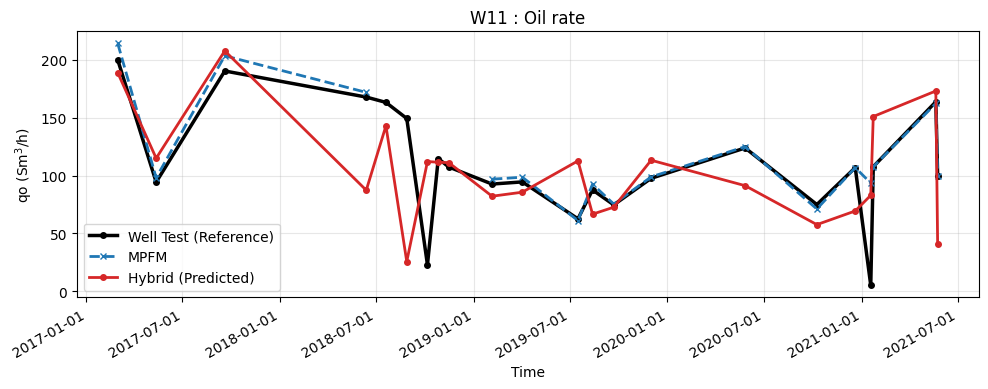

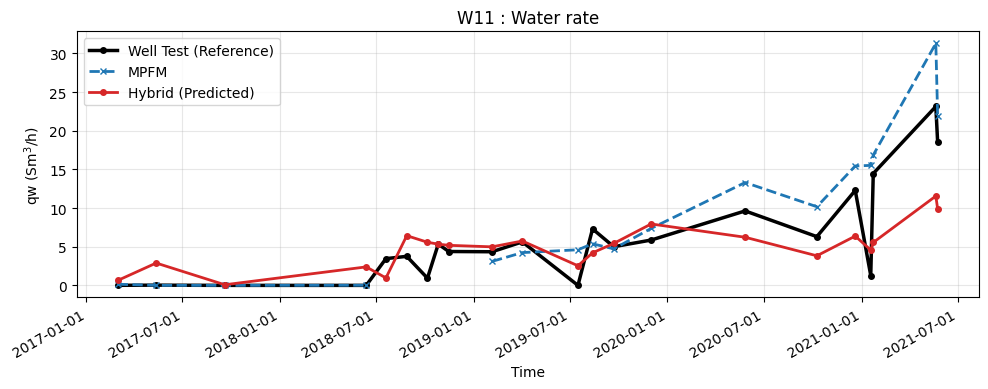

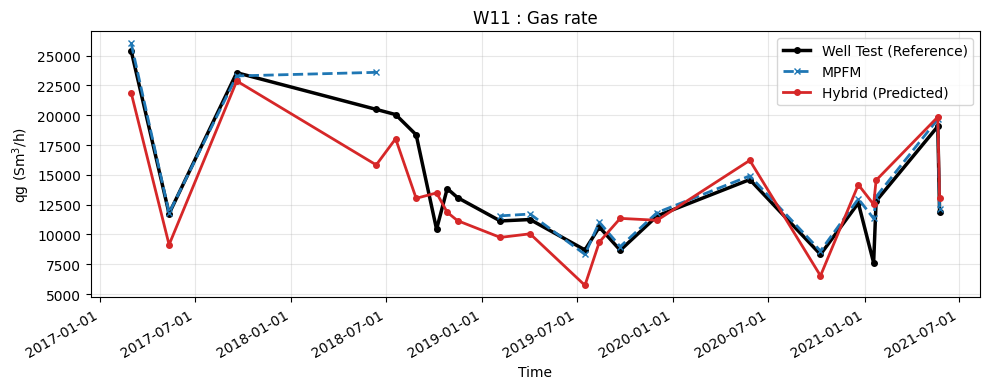

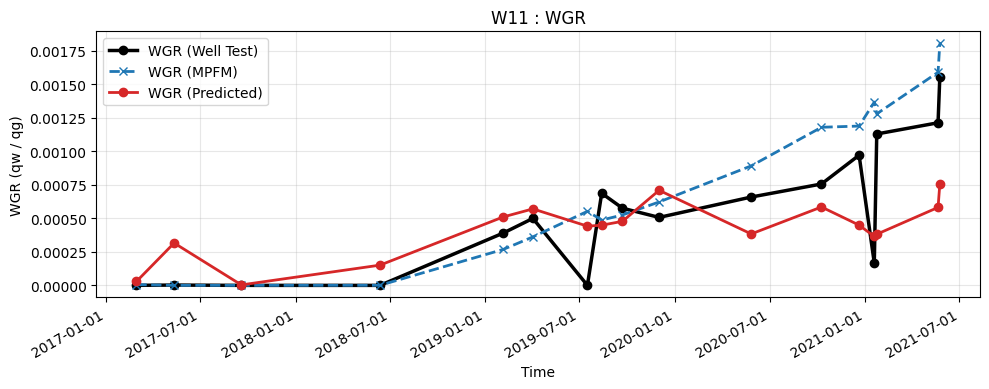

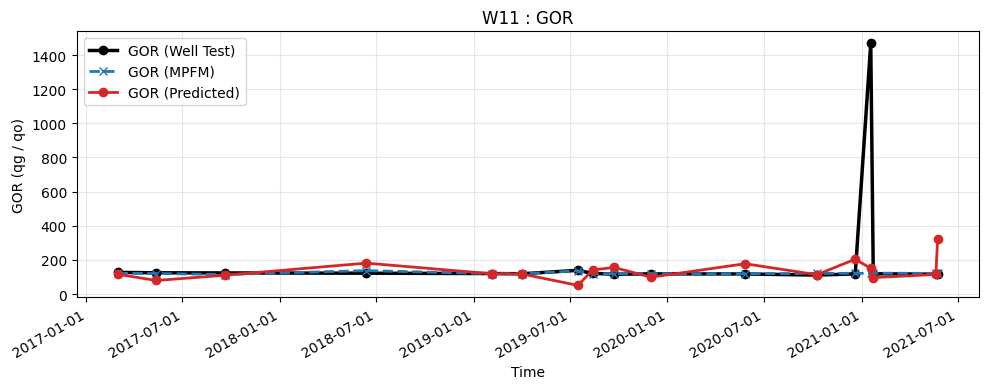

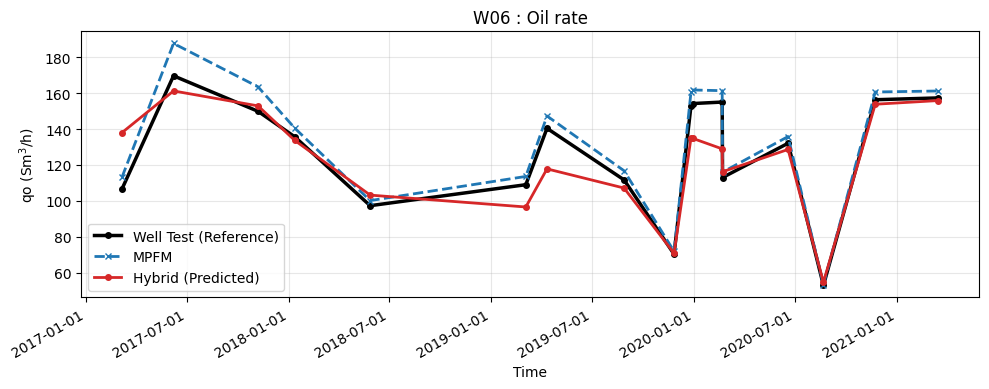

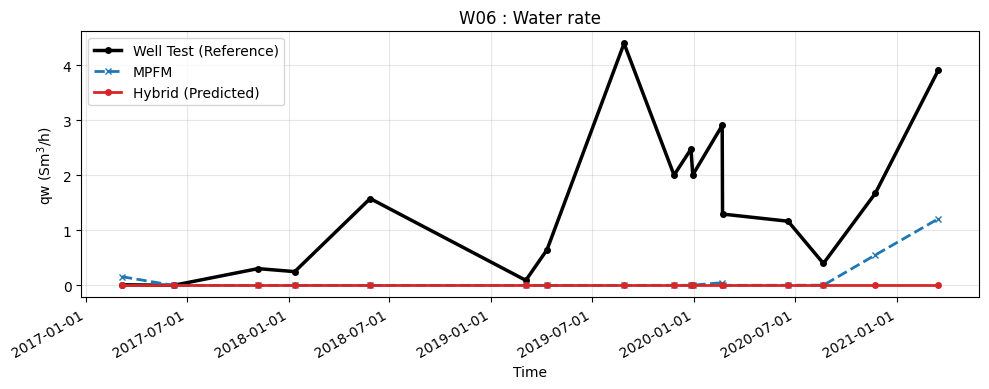

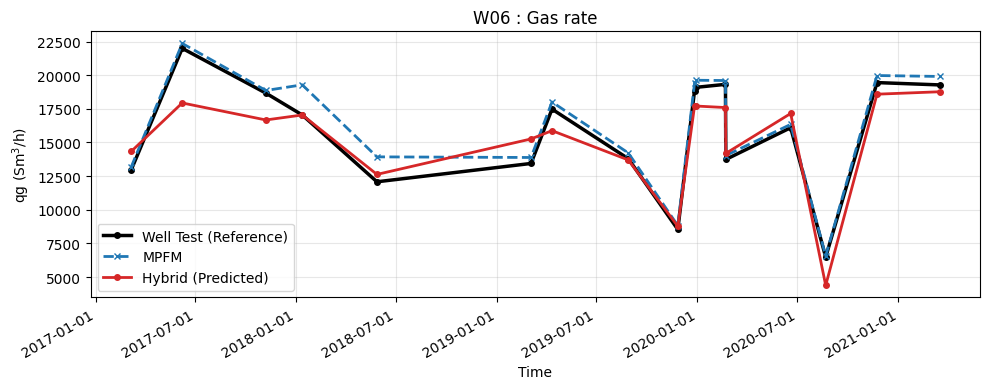

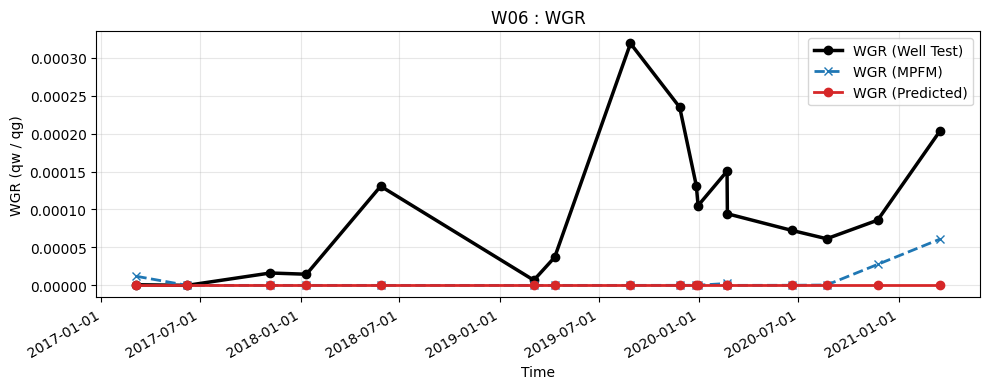

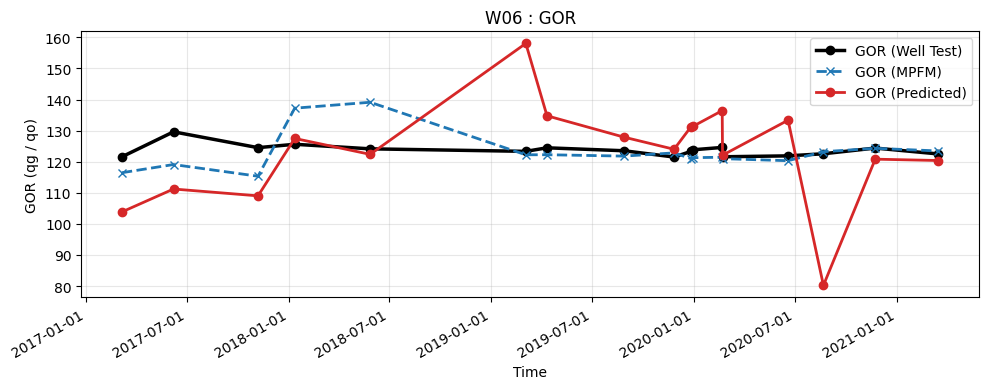

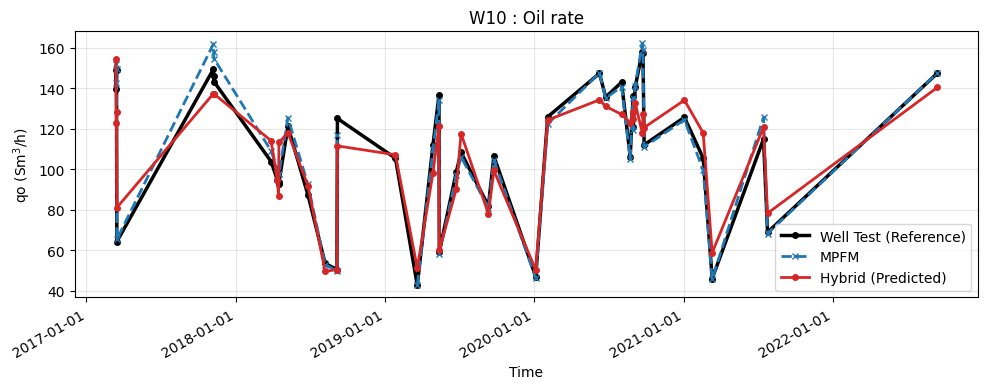

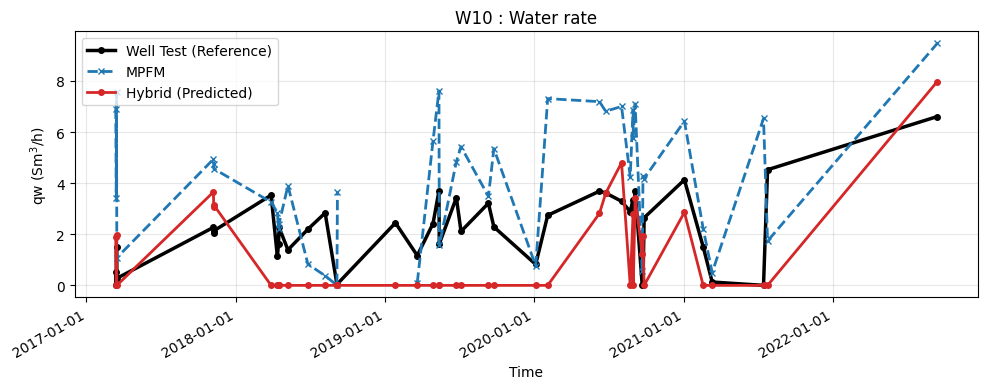

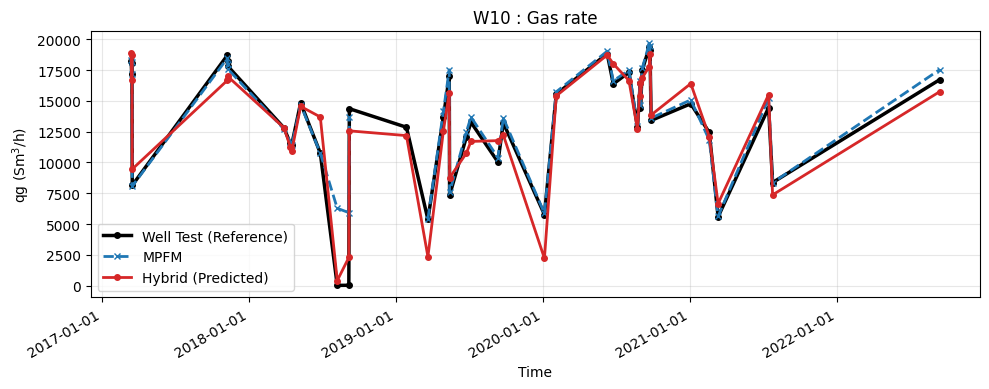

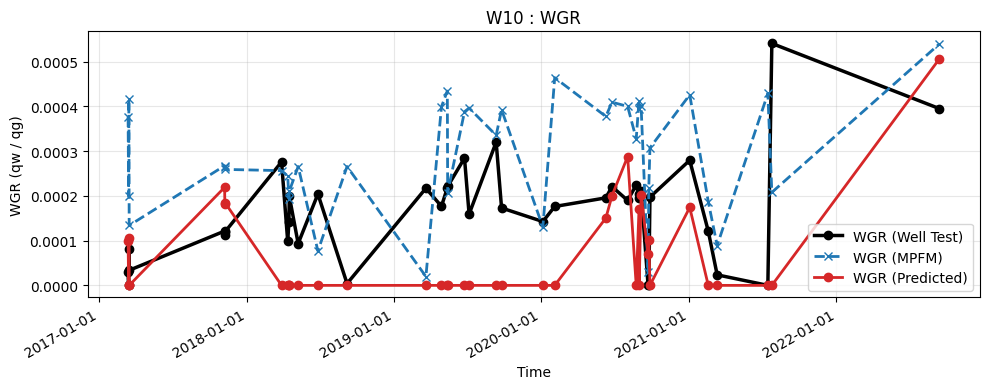

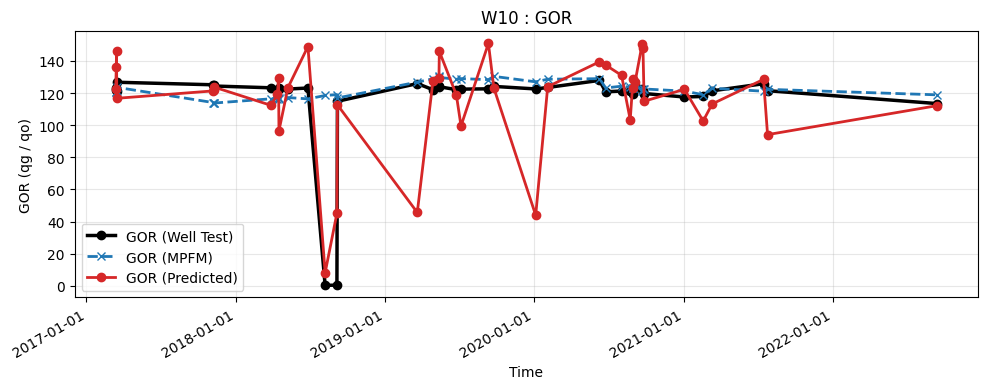

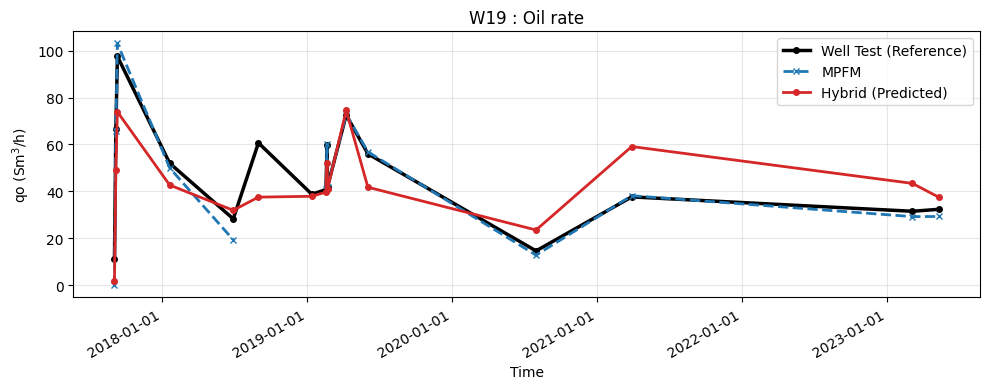

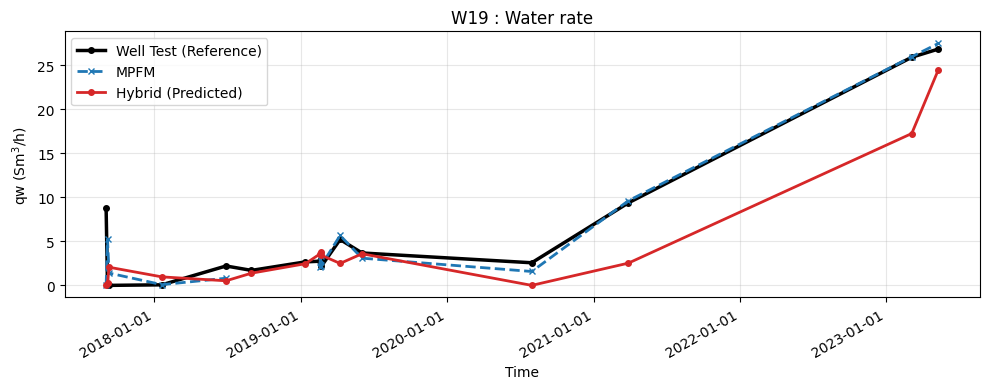

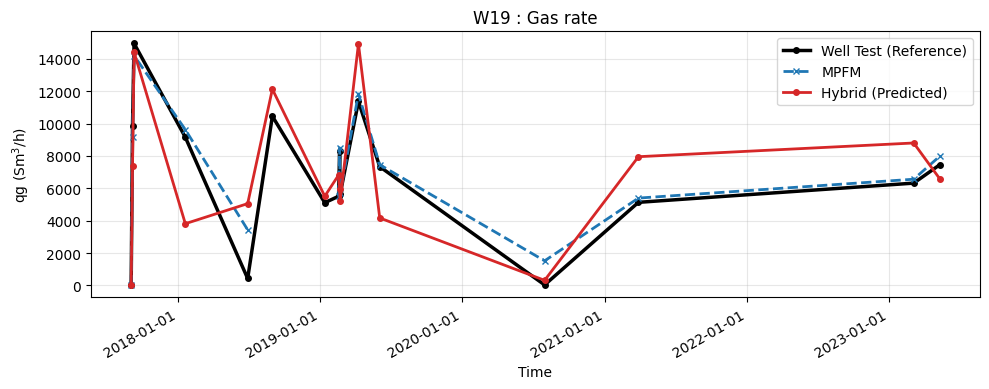

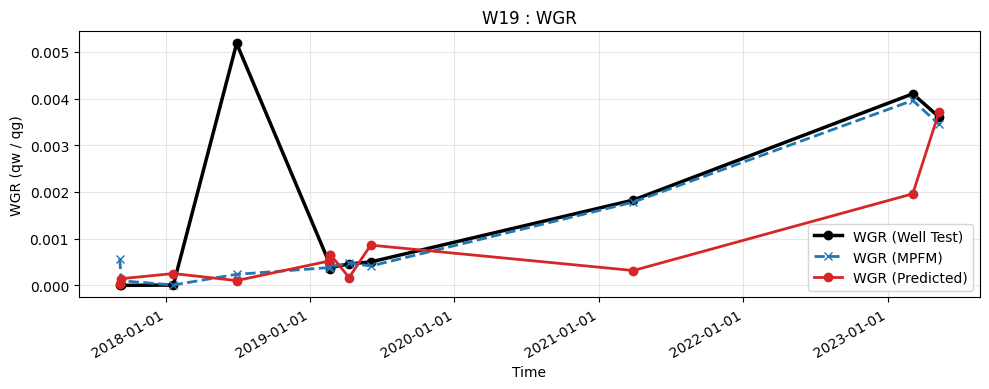

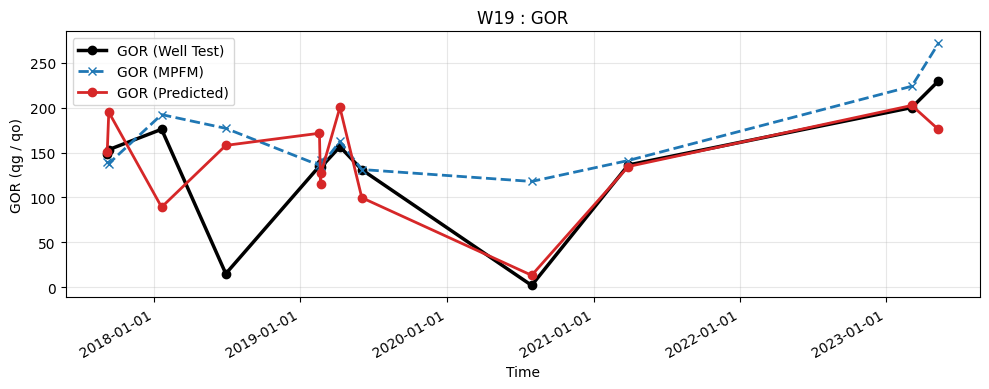

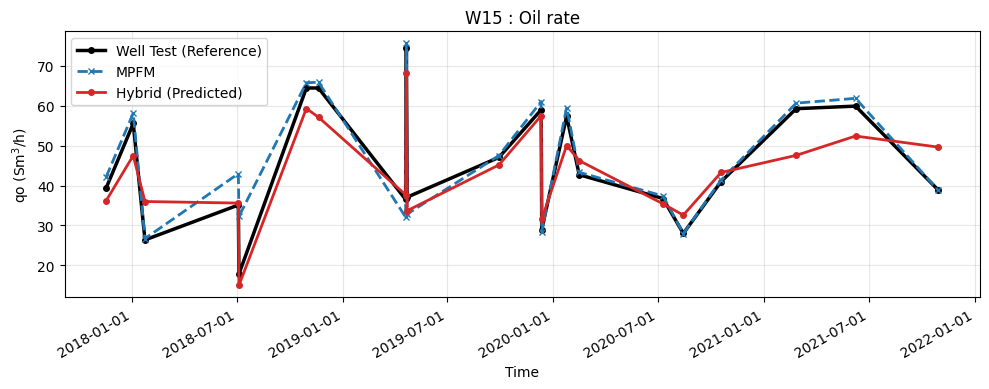

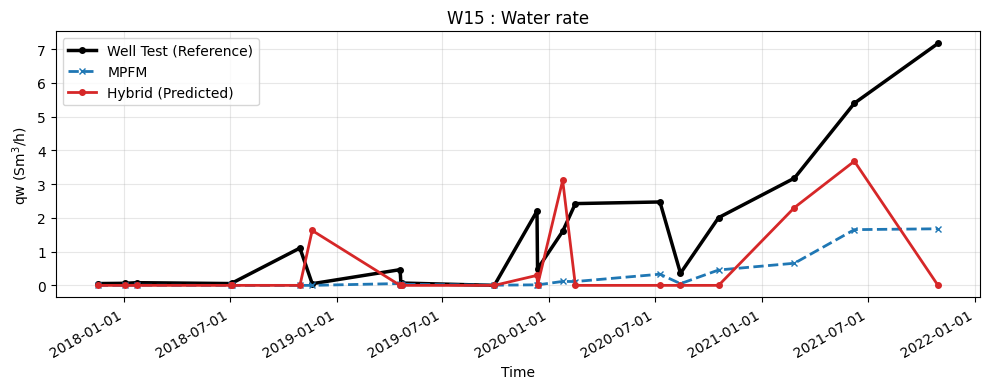

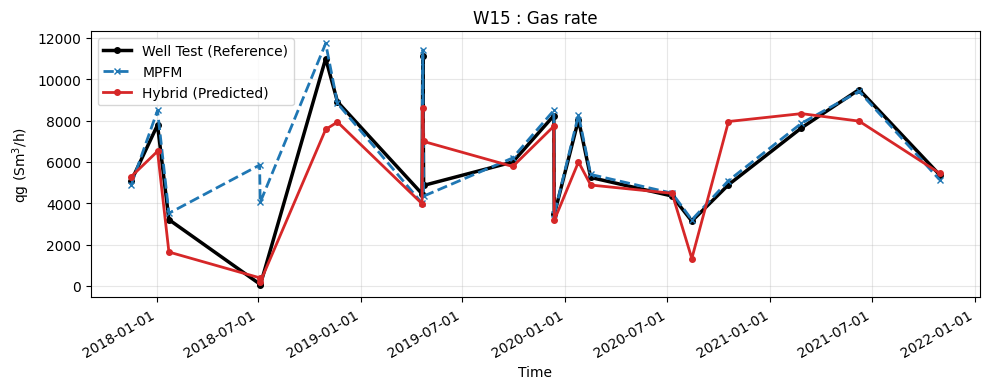

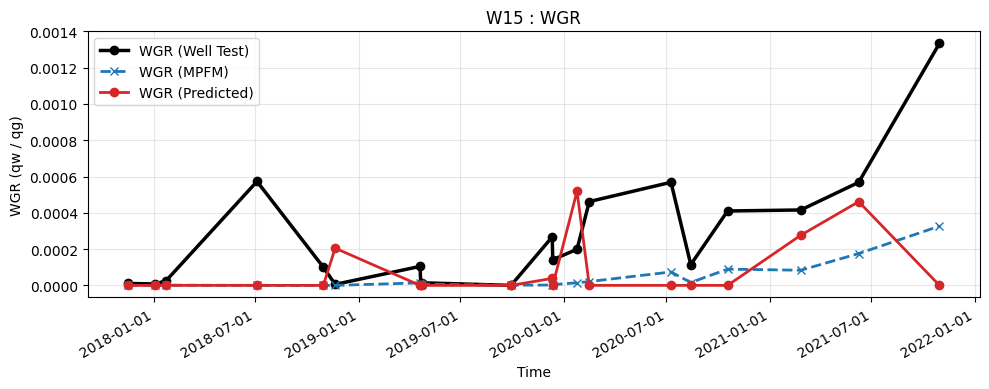

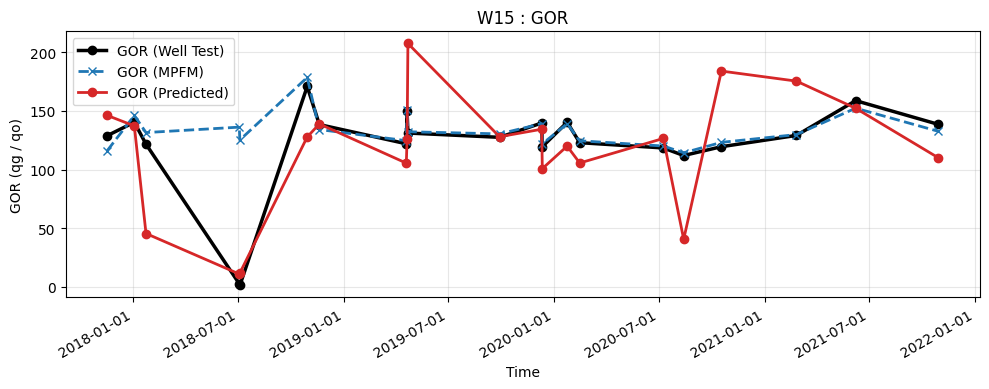

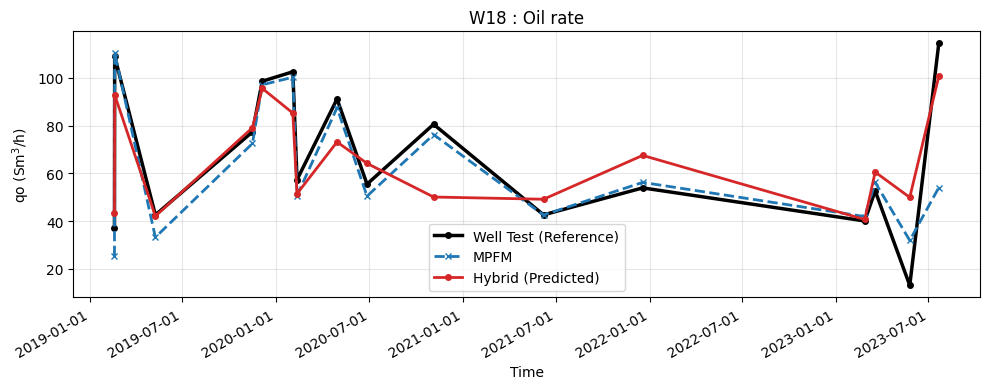

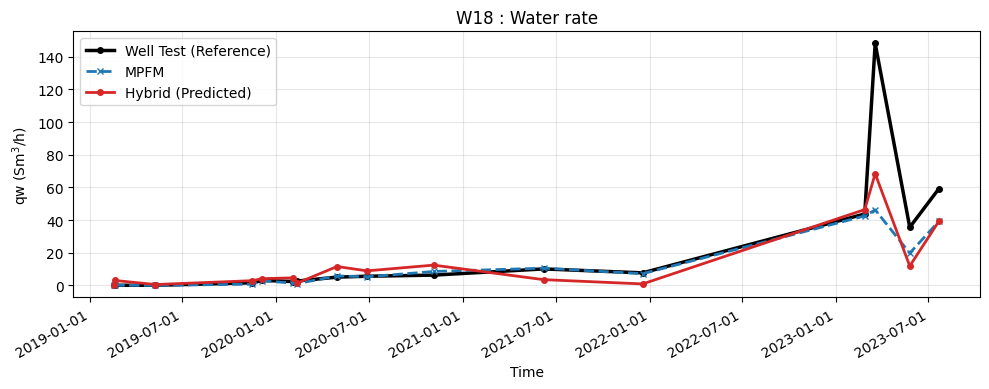

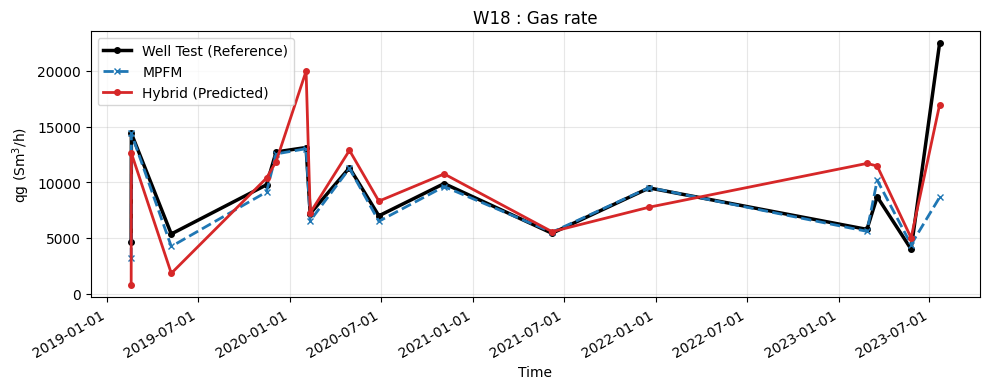

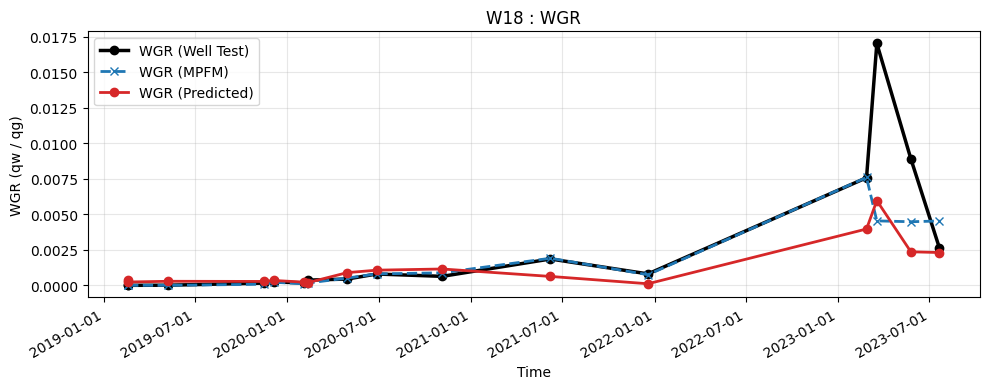

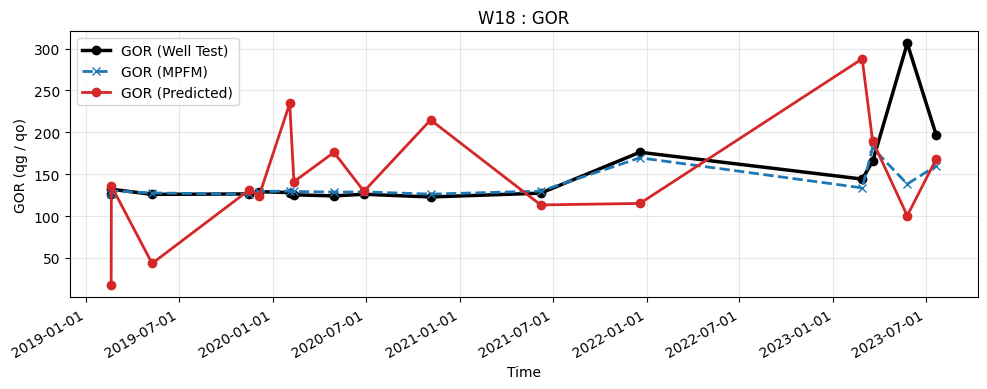

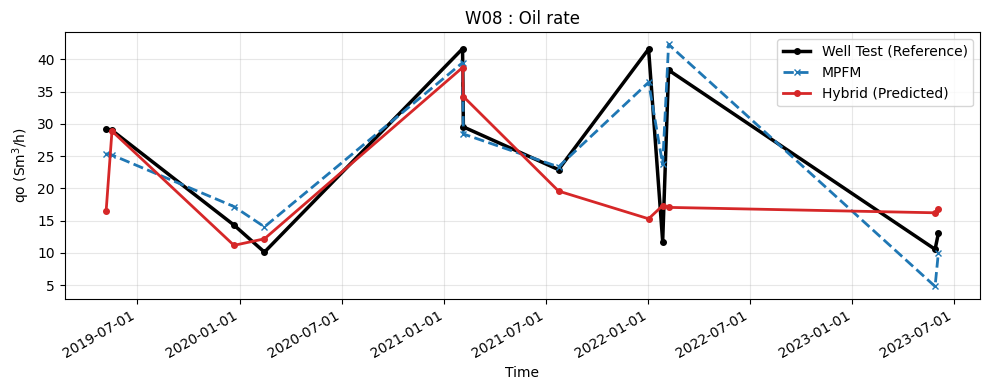

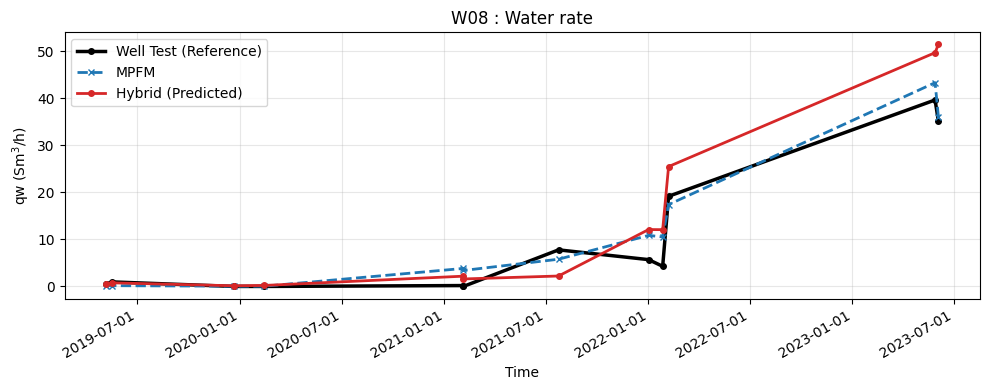

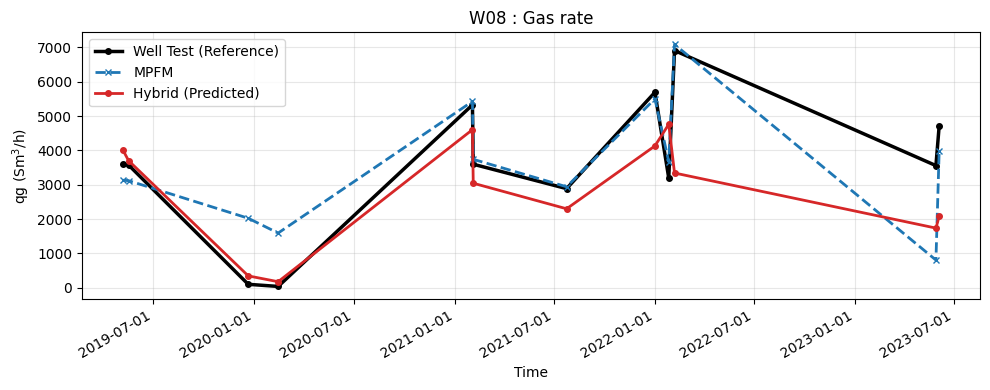

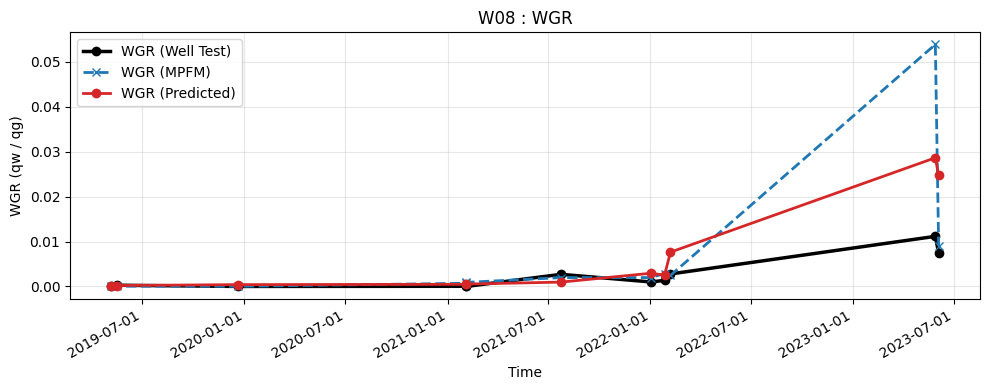

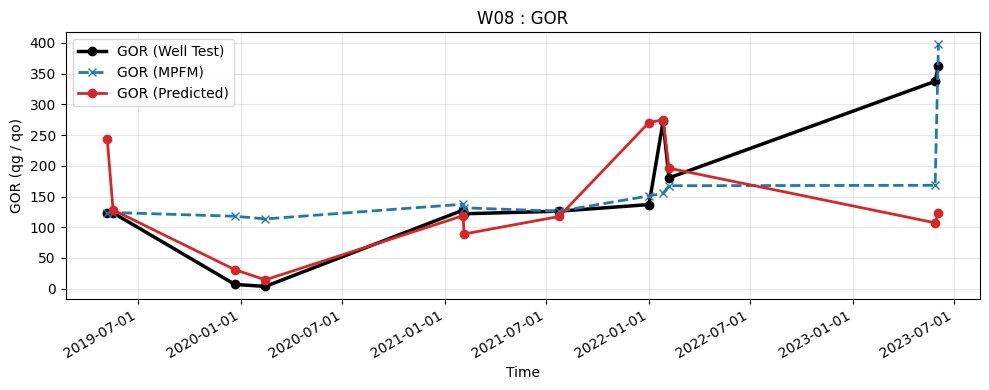

In [37]:
model.plot_predictions(df=df_test, is_hybrid_model=True)

### LOWO test

In [38]:
df_train_lowo, df_val_lowo, df_test_lowo = get_lowo_train_val_test_split(df=df_all_wells_preprocessed, test_well_id="W10")
len(df_train_lowo), len(df_val_lowo), len(df_test_lowo)

(427, 107, 221)

In [39]:
model_lowo = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars, well_geometry=None)
model_lowo.fit(df=df_train_lowo, df_val=df_val_lowo)

[Validation] Residual RMSE = 0.8292


In [40]:
model_lowo.calibrate_physics_only(df=df_test_lowo)

In [41]:
model_lowo.score_physics(df_test_lowo)

{'W10': {'qo': {'r2': 0.47556607433646114,
   'mae': 17.673619283289852,
   'rmse': 23.26900576668434,
   'mape (%)': 19.381442695370303,
   'mpe (%)': 8.482728497727122},
  'qw': {'r2': 0.6396998489882725,
   'mae': 3.2731687203182953,
   'rmse': 6.1805074094121295,
   'mape (%)': 22011.02805104232,
   'mpe (%)': 21932.476605536216},
  'qg': {'r2': 0.691385437494612,
   'mae': 1649.563876159395,
   'rmse': 2271.268719635514,
   'mape (%)': 232.71448572342436,
   'mpe (%)': 217.65237180905382},
  'wgr': {'r2': 0.45557523193624994,
   'mae': 0.00028794772374146513,
   'rmse': 0.0006643996875771597,
   'mape (%)': 125.96550838670599,
   'mpe (%)': 46.96848134019096},
  'gor': {'r2': -1.1536899379404049,
   'mae': 12.462169023049004,
   'rmse': 22.307053433829395,
   'mape (%)': 137.0551698544054,
   'mpe (%)': 120.09949095776436}}}

In [42]:
model_lowo.score_hybrid(df_test_lowo)

{'W10': {'qo': {'r2': 0.743139855047303,
   'mae': 12.547170958579205,
   'rmse': 16.284738897137466,
   'mape (%)': 11.247058699838298,
   'mpe (%)': 3.1767545142516425},
  'qw': {'r2': 0.7304791966946571,
   'mae': 2.955176443240379,
   'rmse': 5.34549657390182,
   'mape (%)': 177.19981773292386,
   'mpe (%)': 36.6034621789929},
  'qg': {'r2': 0.36338633355748917,
   'mae': 2810.2393936788326,
   'rmse': 3262.1076668854844,
   'mape (%)': 58.3800469070786,
   'mpe (%)': 22.678955172444404},
  'wgr': {'r2': 0.5635090338676441,
   'mae': 0.00025216972923810377,
   'rmse': 0.00059490567529144,
   'mape (%)': 85.13823246710913,
   'mpe (%)': -58.00186688783209},
  'gor': {'r2': -6.316722254640938,
   'mae': 32.43317796638684,
   'rmse': 41.11581494900956,
   'mape (%)': 61.842668571378624,
   'mpe (%)': 22.923560584379192}}}

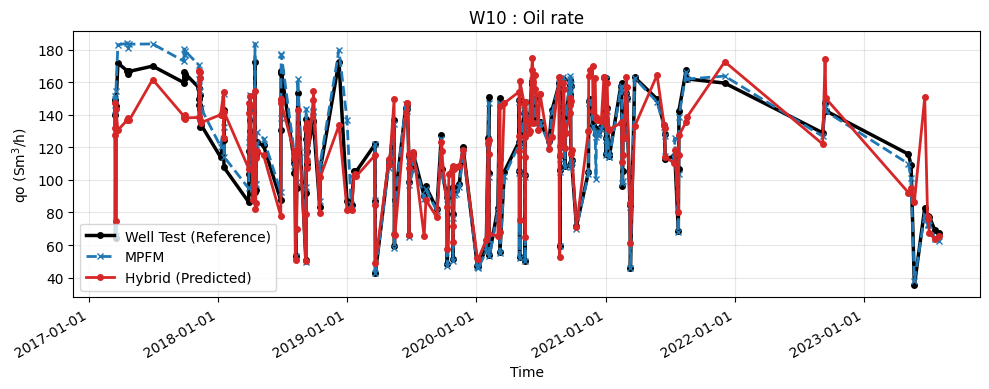

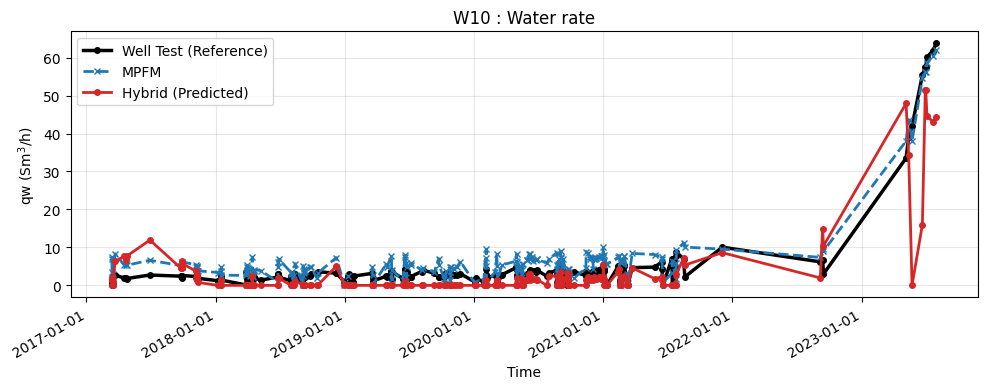

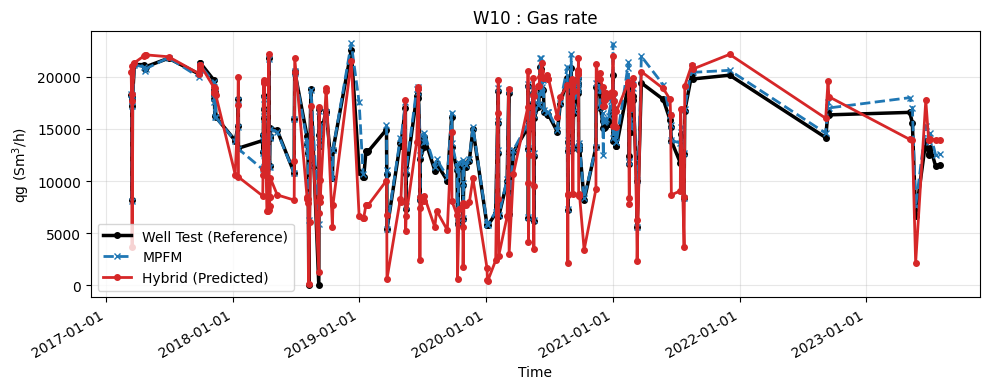

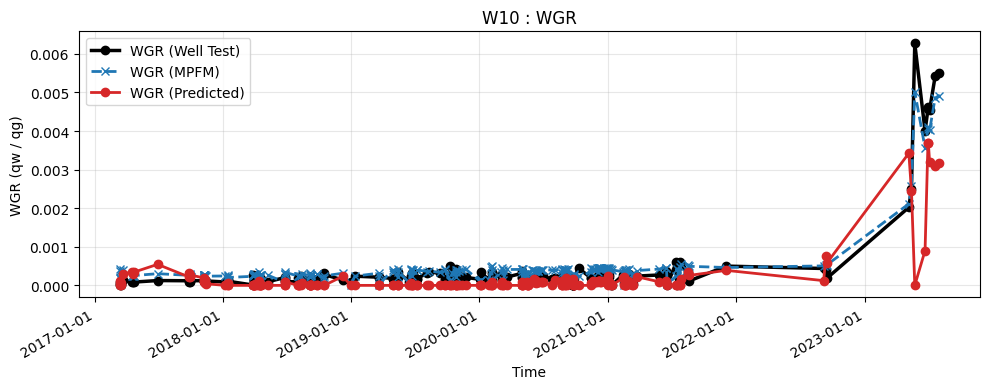

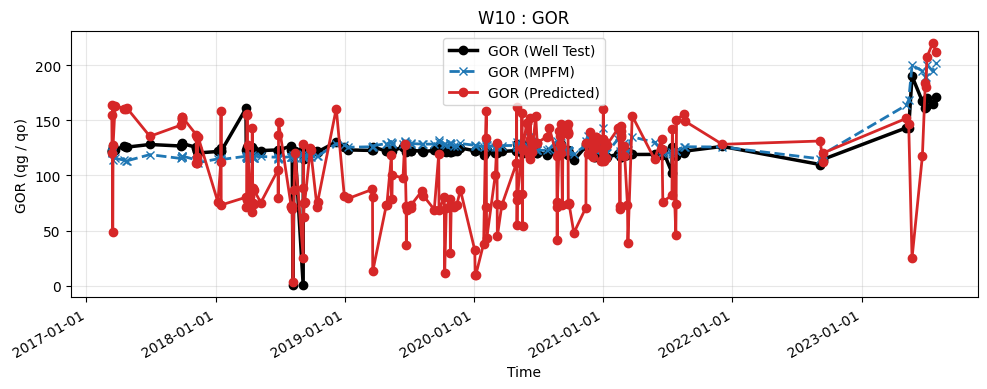

In [43]:
model_lowo.plot_predictions(df=df_test_lowo, model_tag_prefix="lowo")

### Resample and interpolate

In [44]:
resampler = Resampler()
df_resampled = resampler.resample_wells(df=df_all_wells_preprocessed, independent_vars=independent_vars)
print(summarize_null(df=df_resampled))
print(df_resampled.shape)

choke                  0
whp                    0
dcp                    0
dhp                    0
wht                    0
dht                    0
well_code              0
qo_well_test     2054830
qg_well_test     2054830
qw_well_test     2054830
qo_mpfm          2054860
qg_mpfm          2054860
qw_mpfm          2054860
wc_mpfm          2054830
gor_mpfm         2054865
wgr_mpfm         2054866
gor_well_test    2054830
wgr_well_test    2054830
time_idx               0
is_observed            0
well_id                0
dtype: int64
(2055585, 21)


In [45]:
df_resampled.index

RangeIndex(start=0, stop=2055585, step=1)

In [46]:
df_resampled.columns

Index(['choke', 'whp', 'dcp', 'dhp', 'wht', 'dht', 'well_code', 'qo_well_test',
       'qg_well_test', 'qw_well_test', 'qo_mpfm', 'qg_mpfm', 'qw_mpfm',
       'wc_mpfm', 'gor_mpfm', 'wgr_mpfm', 'gor_well_test', 'wgr_well_test',
       'time_idx', 'is_observed', 'well_id'],
      dtype='object')

In [47]:
df_resampled[df_resampled["is_observed"] == 1].shape

(755, 21)

In [48]:
# Monotonic
df_resampled.groupby("well_id")["time_idx"].is_monotonic_increasing

well_id
W06    True
W08    True
W10    True
W11    True
W15    True
W18    True
W19    True
Name: time_idx, dtype: bool

In [49]:
# df_generated = model.generate_dense_well_rates(df=df_resampled)
# df_generated

In [50]:
# summarize_null(df_generated)